c:\Users\Yevhenii_Salii\.conda\envs\oilspills\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42
c:\Users\Yevhenii_Salii\.conda\envs\oilspills\Lib\site-packages\torch\cuda\__init__.py:209: UserWarning: 
NVIDIA GeForce RTX 5070 Ti with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_37 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5070 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


Device:  cuda
__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 5070 Ti
__CUDA Device Total Memory [GB]: 17.094475776
Processing file: 20191027_0001_VV.tif
Number of tiles (x, y): 1, 1
X: 0 Y: 0


c:\Users\Yevhenii_Salii\.conda\envs\oilspills\Lib\site-packages\osgeo\gdal.py:606: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
C:\Users\Yevhenii_Salii\AppData\Local\Temp\ipykernel_31876\3815754616.py:459: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  predict_tensor[k-1, begin_y:end_y, begin_x:end_x] = np.maximum(pred_masks.squeeze().cpu().numpy(), predict_tensor[k-1, begin_y:end_y, begin_x:end_x])


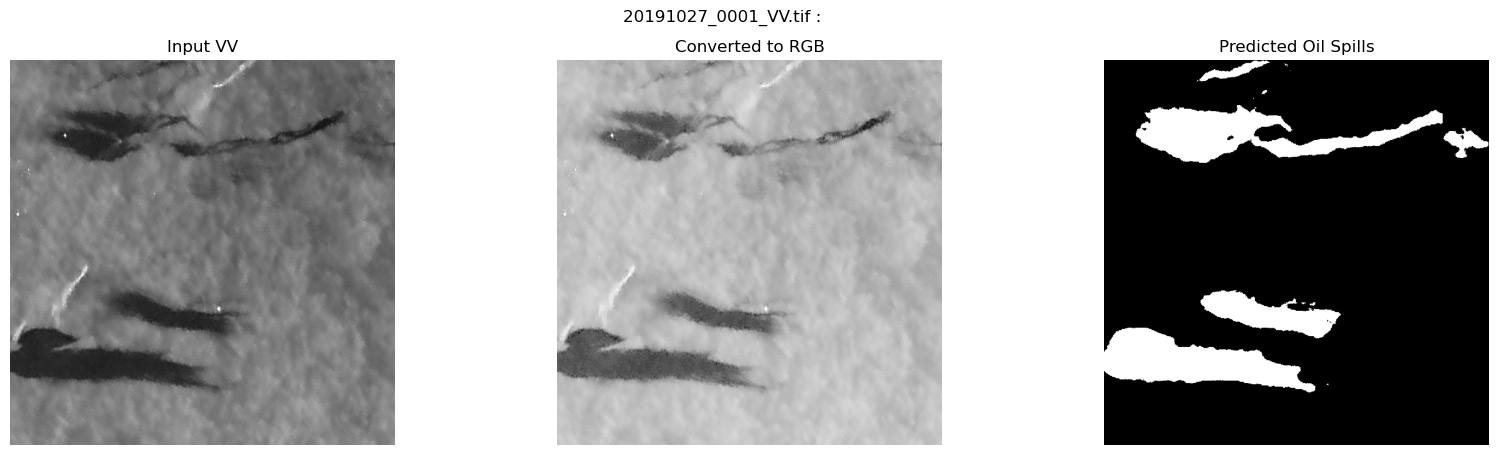

Saving predicted data to GeoTIFF...
Processing file: 20190203_0018_VV.tif
Number of tiles (x, y): 1, 1
X: 0 Y: 0


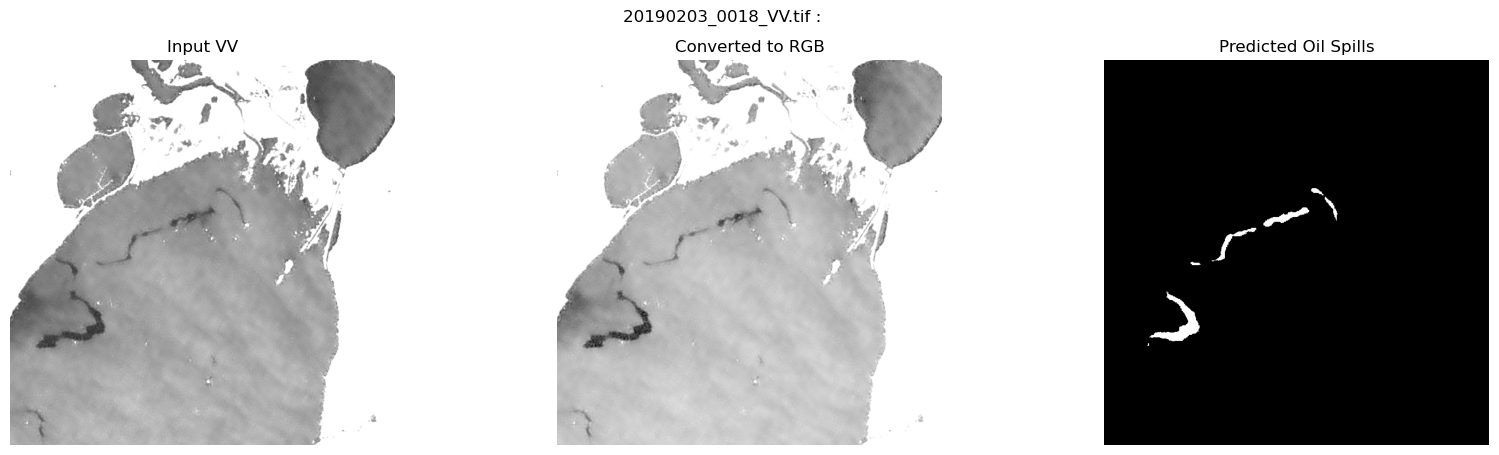

Saving predicted data to GeoTIFF...


In [1]:
# %%
import os
import cv2
import torch
import shutil
import numpy as np
import pandas as pd
import albumentations as A
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from pprint import pprint

from argparse import Namespace
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping


# %%
from osgeo import gdal
from osgeo import ogr
from osgeo import gdalconst


# %%
pl.seed_everything(42, workers=True)
np.random.seed(42)

# %%
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)


# %%
import torch.nn.functional as F
def focal_loss_with_logits(output, target, gamma=2.0, alpha=0.25, reduction='mean', normalized=False, reduced_threshold=None, eps=1e-7):
    # compute the binary cross entropy term
    bce_loss = F.binary_cross_entropy_with_logits(output, target.float(), reduction='none')

    # compute the probability of being classified as positive
    pt = torch.exp(-bce_loss)

    # handle the NoneType error
    if pt is None:
        pt = eps

    # compute the focal term
    if reduced_threshold is None:
        focal_term = (1.0 - pt).pow(gamma)
    else:
        focal_term = ((1.0 - pt) / reduced_threshold).pow(gamma)

    # compute the focal loss
    focal_loss = alpha * focal_term * bce_loss

    # apply reduction
    if reduction == 'mean':
        if normalized:
            num_positives = torch.sum(target > 0.5)
            focal_loss = torch.sum(focal_loss) / (num_positives + eps)
        else:
            focal_loss = torch.mean(focal_loss)
    elif reduction == 'sum':
        focal_loss = torch.sum(focal_loss)

    return focal_loss

# %% [markdown]
# ## Segmentation Model

# %%
class SARModel(pl.LightningModule):

    def __init__(self, hparams_, **kwargs):
        self.hparams_ = hparams_
        super().__init__()
        self.save_hyperparameters()
        self.validation_step_outputs = []
        self.test_step_outputs = []

        # read params passed to the model and use them
        self.learning_rate = hparams_.learning_rate
        self.model = smp.create_model(arch=hparams_.arch_name,
                                      encoder_name=hparams_.encoder_name,
                                      encoder_weights=hparams_.encoder_weights,
                                      # encoder_depth=5,
                                      # psp_out_channels=640,
                                      # upsampling=32,
                                      # decoder_attention_type=hparams_.decoder_attention_type,
                                      in_channels=hparams_.in_channels,
                                      classes=hparams_.out_classes, **kwargs)

        # for image segmentation dice loss could be the best first choice; but other options can also be used
        if hparams_.loss_function == 'DICE':
            self.loss_fn = smp.losses.DiceLoss(mode=smp.losses.BINARY_MODE, from_logits=True)
        elif hparams_.loss_function == 'BCE':
            self.loss_fn = smp.losses.SoftBCEWithLogitsLoss()
        elif hparams_.loss_function == 'FOCAL':
            self.loss_fn = focal_loss_with_logits#smp.losses.FocalLoss(mode=smp.losses.BINARY_MODE, alpha=hparams_.loss_alpha, gamma=hparams_.loss_gamma)
        elif hparams_.loss_function == 'JACCARD':
            self.loss_fn = smp.losses.JaccardLoss(mode=smp.losses.BINARY_MODE, from_logits=True)
        elif hparams_.loss_function == 'LOVASZ':
            self.loss_fn = smp.losses.LovaszLoss(mode=smp.losses.BINARY_MODE, from_logits=True)
        elif hparams_.loss_function == 'TVERSKY':
            self.loss_fn = smp.losses.TverskyLoss(mode=smp.losses.BINARY_MODE, alpha=hparams_.loss_alpha, beta=hparams_.loss_beta, gamma=hparams_.loss_gamma, from_logits=True)

    def forward(self, image):
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        self.log(f"{stage}_loss", loss)

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        per_image_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        dataset_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_per_image_f1": per_image_f1,
            f"{stage}_dataset_f1": dataset_f1,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def train_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(loss)
        return loss

    def on_validation_epoch_end(self):
        epoch_average = self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return epoch_average

    def test_step(self, batch, batch_idx):
        loss = self.shared_step(batch, "test")
        self.test_step_outputs.append(loss)
        return loss

    def on_test_epoch_end(self):
        epoch_average = self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()
        return epoch_average

    def configure_optimizers(self):
        # return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=3, factor=0.1)
        return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": scheduler,
                                 "monitor": 'valid_loss',
                                 "interval": 'epoch',
                                 "frequency": 1
                                }
               }

# VV2RGB: dB
CONST_NORM = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0)
NORM_MEAN = (0.485, 0.456, 0.406)
NORM_STD = (0.229, 0.224, 0.225)
NODATA_RGB = [255, 255, 255]
CONST_NORM = A.Normalize(mean=NORM_MEAN, std=NORM_STD, max_pixel_value=255.0, p=1.0)
def convert_db_norm_data(data, show_plot=False):
    tiff_uc = data#cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    tiff_uc = data.astype('float32')

    tiff_uc[~np.isfinite(tiff_uc)] = -1

    # valid = tiff_uc[tiff_uc > 0]
    tiff_uc[tiff_uc <= 0] = np.max(tiff_uc)
    # src = cv2.dilate(src, np.ones((13, 13)))
    # HACK for smoothing very noisy images. Works for images on very large scale and with very intense noise
    # tiff_uc = cv2.morphologyEx(tiff_uc, cv2.MORPH_CLOSE, np.ones((13, 13)))

    tiff_uc[tiff_uc == 0] = np.max(tiff_uc)
    tiff_db = np.multiply(np.log10(tiff_uc), 20)
    tiff_db_norm = cv2.normalize(tiff_db, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    tiff_db_norm_rgb = cv2.cvtColor(tiff_db_norm, cv2.COLOR_GRAY2RGB)
    if show_plot is True:
        plt.imshow(tiff_db_norm_rgb, cmap="gray")
        plt.show()
    return tiff_db_norm_rgb

# VV2RGB: 3way
# NORM_MEAN = (0.5, 0.5, 0.5)
# NORM_STD = (1, 1, 1)
# NODATA_RGB = [255, 255, 255]
# CONST_NORM = A.Normalize(mean=NORM_MEAN, std=NORM_STD, max_pixel_value=255.0, p=1.0)
# def cv2_pooling(src):
#     stride = 32
#     mean_map = cv2.filter2D(src, -1, np.ones((stride, stride)) / stride**2)
#     std_map = cv2.filter2D(src**2 - 2 * src * mean_map + mean_map**2, -1, np.ones((stride, stride)) / stride**2)

#     pooled_map = mean_map[::stride, ::stride]
#     pooled_map_std = np.maximum(5e-3, std_map[::stride, ::stride])

#     dst_shape = (src.shape[1], src.shape[0])

#     pooled_map = cv2.GaussianBlur(pooled_map, (7, 7), 0)
#     pooled_map = cv2.resize(pooled_map, dst_shape)

#     pooled_map_std = cv2.GaussianBlur(pooled_map_std, (7, 7), 0)
#     pooled_map_std = cv2.resize(pooled_map_std, dst_shape)

#     return (src - pooled_map) / pooled_map_std

# def convert_db_norm_data(src):
#     vv = src
#     mask = np.isfinite(vv) & (vv > 0) & (vv < 0.1)

#     mean = np.mean(mask)
#     std = np.std(mask)

#     vv[~mask] = 0.1

#     # HACK for smoothing very noisy images. Works for images on very large scale and with very intense noise
#     # vv = cv2.morphologyEx(vv, cv2.MORPH_CLOSE, np.ones((13, 13)))

#     r = 20 * np.log10(vv)
#     g = (np.arctan((vv - mean) / (std)) + 0.5 * np.pi) / np.pi
#     b = (np.arctan(cv2_pooling(vv) / 2) + 0.5 * np.pi) / np.pi

#     r = cv2.normalize(r, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     g = (255 * g).astype("uint8")
#     b = (255 * b).astype("uint8")

#     r[~mask] = 255
#     g[~mask] = 255
#     b[~mask] = 255

#     rgb = cv2.merge([r, g, b])

#     return rgb

# %%
def rasterize_layer(shp, geotransform, projection, date, data):
  mb_l = shp.GetLayer()

  saf = mb_l.SetAttributeFilter(f"layer LIKE '{date}%'")

  target_ds = gdal.GetDriverByName('MEM').Create('', data.RasterXSize, data.RasterYSize, 1, gdal.GDT_Byte)

  if geotransform is not None:
    target_ds.SetGeoTransform( geotransform )

  if projection is not None:
    target_ds.SetProjection( projection )

  band = target_ds.GetRasterBand(1)
  NoData_value = 0 #-999999
  band.SetNoDataValue(NoData_value)
  band.Fill(0)
  band.FlushCache()
  ds = gdal.RasterizeLayer(target_ds, [1], mb_l, burn_values=[1], options = ['ALL_TOUCHED=TRUE'])
  ds = None
  # target_ds = None
  return target_ds

# %%
# example, github dont contain model weights
models_dict = {
    "dB": {
        "path": 'models/S1-640-REF-LinkNet-efficientnet-b4-imagenet-dB-default_e4-epoch=51-valid_loss=0.36.ckpt' 
    },
    "3way": {
        "path": 'models/S1-640-REF-LinkNet-efficientnet-b4-imagenet-3way-default-epoch=54-valid_loss=0.34.ckpt'
    },
}

# TO USE SPECIFIED MODEL, UNCOMMENT SPECIFIED VV2RGB above: dB or 3way
chk_path = models_dict["dB"]["path"]
model_best = SARModel.load_from_checkpoint(chk_path)
image_dir = r'E:\iMermaid_codebase\images'
output_dir = 'output'
shp = None

os.makedirs(output_dir, exist_ok=True)

listdir = os.listdir(image_dir)
listdir = sorted(listdir, reverse=True)

for file_name in listdir:
  print(f"Processing file: {file_name}")

  if file_name.startswith("DEM-"):
    continue

  gtif = gdal.Open(os.path.join(image_dir, file_name))

  if 'dem' in file_name:
    continue

  dem_file = os.path.join(image_dir, file_name[:-4] + '-dem.tif')
  if os.path.exists(dem_file):
    dem_ds = gdal.Open(dem_file)
    dem = dem_ds.GetRasterBand(1).ReadAsArray()
  else:
    dem = None

  if gtif is None:
    continue

  projection   = gtif.GetProjection()
  geotransform = gtif.GetGeoTransform()

  image_width = gtif.RasterXSize
  image_height = gtif.RasterYSize
  divisor = 32

  image_width_padded = image_width
  if image_width % divisor != 0:
    image_width_padded += divisor - image_width % divisor

  image_height_padded = image_height
  if image_height % divisor != 0:
    image_height_padded += divisor - image_height % divisor

  transforms = A.Compose([
      A.augmentations.geometric.transforms.PadIfNeeded(min_height=image_height_padded, min_width=image_width_padded),
      CONST_NORM
      ])

  predict_tensor = torch.zeros((gtif.RasterCount, image_height_padded, image_width_padded), dtype=torch.int8)
  for k in range(1, gtif.RasterCount + 1):
    band = gtif.GetRasterBand(k)
    band_name = band.GetDescription()

    data = band.ReadAsArray()
    # IN CASE DATA IS IN LINEARSPACE (all values > 0)
    data = np.clip(data, 0, 0.2)
    # IN CASE DATA IS IN LOG10-SPACE (can have negative values). Scale coeficient '10' in below is empirically determined.
    # data = np.clip(np.power(10, data / 10), 0, 0.2)

    if dem is not None:
      data[dem > 0] = 0


    date = band_name.split('_')[0]

    mask_tif = None
    if shp is not None:
      mask_tif = rasterize_layer(shp, geotransform, projection, date, gtif)

    # CHUNK SIZE MUST BE <= DIMENSION OF THE IMAGE, overwise it will skip image and produce empty mask.
    chunk_size = 640

    input_np = convert_db_norm_data(data)
    input_tensor = input_np
    input_tensor = transforms(image=input_tensor)['image']

    input_tensor = input_tensor.swapaxes(0, 2).swapaxes(1, 2)
    input_tensor = input_tensor.reshape(1, 3, image_height_padded, image_width_padded)
    input_tensor = torch.from_numpy(input_tensor).cuda()

    tiles_y = int(np.ceil(input_tensor.shape[2]/chunk_size))
    tiles_x = int(np.ceil(input_tensor.shape[3]/chunk_size))

    print(f"Number of tiles (x, y): {tiles_x}, {tiles_y}")
    for x in range(0, input_tensor.shape[3] - chunk_size // 2, chunk_size // 2):
      for y in range(0, input_tensor.shape[2] - chunk_size // 2, chunk_size // 2):
        print(f"X: {x} Y: {y}")
        begin_x = x
        end_x = begin_x + np.min([chunk_size, input_tensor.shape[3] - begin_x])

        begin_y = y
        end_y = begin_y + np.min([chunk_size, input_tensor.shape[2] - begin_y])

        with torch.no_grad():
            model_best.eval()
            logits_best = model_best(input_tensor[:, :, begin_y:end_y, begin_x:end_x]).cuda()

        pred_masks = logits_best.sigmoid()
        pred_masks = (pred_masks > 0.5).int()

        predict_tensor[k-1, begin_y:end_y, begin_x:end_x] = np.maximum(pred_masks.squeeze().cpu().numpy(), predict_tensor[k-1, begin_y:end_y, begin_x:end_x])

    plt.figure(figsize=(20, 5))
    plt.suptitle(f"{file_name} : {band_name}")

    plt.subplot(1, 3, 1)
    plt.imshow(data, cmap="gray", vmin=0, vmax=0.2)
    plt.title("Input VV")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(input_np, cmap="gray", vmin=0, vmax=0.2)
    plt.title("Converted to RGB")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predict_tensor[k-1], vmin=0, vmax=1, cmap="gray")
    plt.title("Predicted Oil Spills")
    plt.axis("off")

    plt.show()


  print("Saving predicted data to GeoTIFF...")

  dataset = gtif

  projection   = dataset.GetProjection()
  geotransform = dataset.GetGeoTransform()

  driver = gdal.GetDriverByName("GTiff")
  outdata = driver.Create(os.path.join(output_dir, f'Predict_{file_name}'), xsize=dataset.RasterXSize, ysize=dataset.RasterYSize, bands=gtif.RasterCount, eType=gdal.GDT_Byte, options=['COMPRESS=LZW'])

  if geotransform is not None:
    outdata.SetGeoTransform( geotransform )

  if projection is not None:
    outdata.SetProjection( projection )

  for k in range(1, gtif.RasterCount + 1):
    write_data = predict_tensor[k-1, :dataset.RasterYSize, :dataset.RasterXSize].numpy().astype(np.uint8)

    outband = outdata.GetRasterBand(k)
    outband.WriteArray(write_data)

  outdata = None